## Load Pre Processed Dataset

In [1]:
import zipfile
import pandas as pd

with zipfile.ZipFile("/content/drive/MyDrive/Student/Mohit/Dataset/Skin_Cancer_Malignant_vs_Benign/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


train_load_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/train_df.csv'
test_load_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/test_df.csv'
val_load_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/val_df.csv'

# Loading dataframes from the CSV files
train_df = pd.read_csv(train_load_path)
test_df = pd.read_csv(test_load_path)
val_df = pd.read_csv(val_load_path)

print("Train DataFrame:")
display(train_df)

print("\nTest DataFrame:")
display(test_df)

print("\nValidation DataFrame:")
display(val_df)

Train DataFrame:


,file_path,label
0,/content/data/train/benign/183.jpg,benign
1,/content/data/train/benign/852.jpg,benign
2,/content/data/train/benign/1515.jpg,benign
3,/content/data/train/benign/807.jpg,benign
4,/content/data/train/benign/1580.jpg,benign
...,...,...
2632,/content/data/train/malignant/685.jpg,malignant
2633,/content/data/train/malignant/1481.jpg,malignant
2634,/content/data/train/malignant/1247.jpg,malignant
2635,/content/data/train/malignant/550.jpg,malignant



Test DataFrame:


,file_path,label
0,/content/data/test/benign/878.jpg,benign
1,/content/data/test/malignant/1026.jpg,malignant
2,/content/data/test/malignant/1499.jpg,malignant
3,/content/data/test/benign/1350.jpg,benign
4,/content/data/test/benign/894.jpg,benign
...,...,...
325,/content/data/test/benign/626.jpg,benign
326,/content/data/test/benign/824.jpg,benign
327,/content/data/test/benign/1412.jpg,benign
328,/content/data/test/malignant/237.jpg,malignant



Validation DataFrame:


,file_path,label
0,/content/data/test/malignant/317.jpg,malignant
1,/content/data/test/malignant/1074.jpg,malignant
2,/content/data/test/benign/1655.jpg,benign
3,/content/data/test/malignant/706.jpg,malignant
4,/content/data/test/benign/1479.jpg,benign
...,...,...
325,/content/data/test/malignant/1333.jpg,malignant
326,/content/data/test/benign/317.jpg,benign
327,/content/data/test/benign/1208.jpg,benign
328,/content/data/test/malignant/1056.jpg,malignant


## Now Prepare Images

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df_train = train_df
df_test = test_df
df_val = val_df

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])
df_val['label'] = label_encoder.transform(df_val['label'])

print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

print("Train set class distribution:")
print(df_train['label'].value_counts())
print("\nTest set class distribution:")
print(df_test['label'].value_counts())
print("\nVal set class distribution:")
print(df_val['label'].value_counts())

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
Train set class distribution:
label
0    1440
1    1197
Name: count, dtype: int64

Test set class distribution:
label
1    166
0    164
Name: count, dtype: int64

Val set class distribution:
label
0    196
1    134
Name: count, dtype: int64
Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


## Now Creating ML Model and EfficientNetB0 as Features Extractor

In [3]:
import numpy as np
import time
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Build ResNet50 feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
feature_model = Model(inputs=base_model.input, outputs=x)
base_model.trainable = False

# Feature extraction function
def extract_features(generator, feature_model):
    features, labels = [], []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        feat = feature_model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels)

# Extract and time features
start_time = time.time()
X_train, y_train = extract_features(train_generator, feature_model)
X_val, y_val = extract_features(val_generator, feature_model)
X_test, y_test = extract_features(test_generator, feature_model)
end_time = time.time()
print(f"\nFeature extraction time: {end_time - start_time:.2f} seconds")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 11/11 [00:02<00:00,  5.12it/s]


Feature extraction time: 45.51 seconds


In [4]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss'
)

start_time = time.time()
xgb_clf.fit(X_train, y_train)
end_time = time.time()
print(f"XGBoost training time: {end_time - start_time:.2f} seconds")


XGBoost training time: 151.09 seconds


### Test Set

Test evaluation time: 0.01 seconds

Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88       164
   malignant       0.88      0.88      0.88       166

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



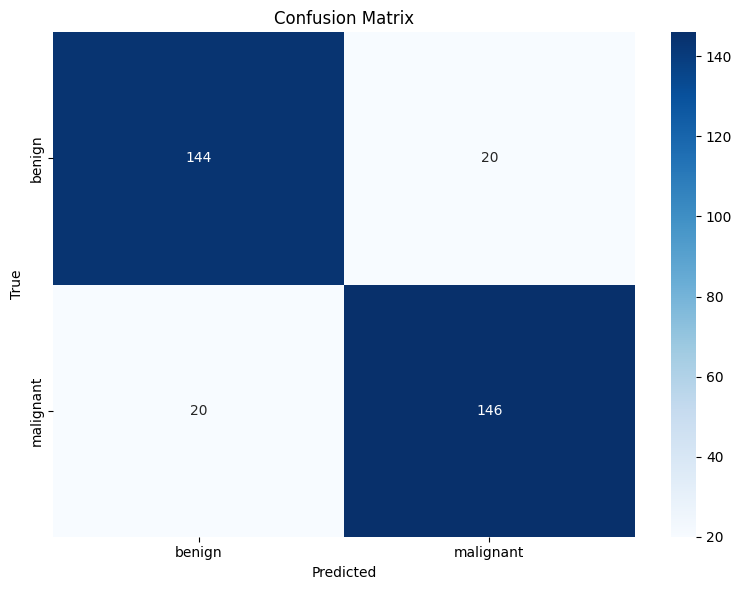

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

start_time = time.time()
y_pred = xgb_clf.predict(X_test)
end_time = time.time()

print(f"Test evaluation time: {end_time - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


### Val Set

Val evaluation time: 0.01 seconds

Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.88      0.90       196
   malignant       0.83      0.90      0.87       134

    accuracy                           0.89       330
   macro avg       0.88      0.89      0.89       330
weighted avg       0.89      0.89      0.89       330



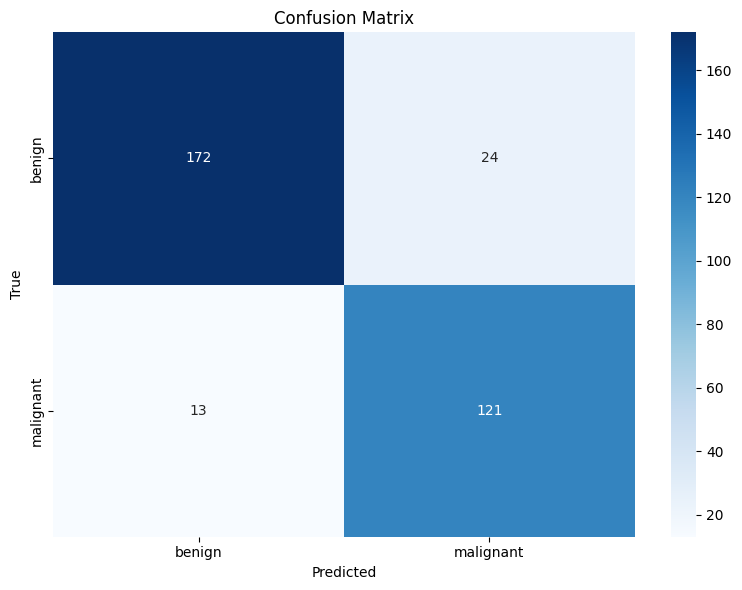

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

start_time = time.time()
y_pred = xgb_clf.predict(X_val)
end_time = time.time()

print(f"Val evaluation time: {end_time - start_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Finally saving the model

In [7]:
import joblib
import shutil

joblib.dump(xgb_clf, 'XGB_ResNet50_model.pkl')

destination = '/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/ML_Models/XGB_ResNet50/XGB_ResNet50_model.pkl'
shutil.move('XGB_ResNet50_model.pkl', destination)

print(f'Model saved to {destination}')

Model saved to /content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/ML_Models/XGB_ResNet50/XGB_ResNet50_model.pkl


## Load The model (If need)

In [ ]:
import joblib

xgb_loaded = joblib.load('/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/ML_Models/XGB_ResNet50/XGB_ResNet50_model.pkl')
